In [2]:
import time
import numpy as np

import torch
import torch.nn.functional as F

from torchvision import datasets
from torchvision import transforms

import torch.nn as nn
from torch.utils.data import DataLoader

if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

random_seed = 123
generator_learning_rate = 0.001
discriminator_learning_rate = 0.001
num_epochs = 100
batch_size = 128
LATENT_DIM = 100
IMG_SHAPE = (1, 28, 28)
IMG_SIZE = 1
for x in IMG_SHAPE:
    IMG_SIZE *= x

train_dataset = datasets.MNIST(root = 'data',
                               train = True,
                               transform = transforms.ToTensor(),
                               download = True)
test_dataset = datasets.MNIST(root = 'data',
                              train=False,
                              transform = transforms.ToTensor())

train_loader = DataLoader(train_dataset,
                          batch_size = batch_size,
                          shuffle = True)

test_loader = DataLoader(test_dataset,
                         batch_size = batch_size,
                         shuffle = False)

for images, labels in train_loader:
    print(images.shape)
    print(labels.shape)
    break

torch.Size([128, 1, 28, 28])
torch.Size([128])


In [19]:

class GAN(torch.nn.Module):

    def __init__(self):
        super(GAN, self).__init__()

        self.generator = nn.Sequential(
            nn.Linear(LATENT_DIM, 128),
            nn.LeakyReLU(inplace = True),
            nn.Dropout(p=0.5),
            nn.Linear(128, IMG_SIZE),
            nn.Tanh()
        )

        self.discriminator = nn.Sequential(
            nn.Linear(IMG_SIZE, 128),
            nn.LeakyReLU(inplace = True),
            nn.Dropout(p=0.5),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def generator_forward(self, z):
        img = self.generator(z)
        return img

    def discriminator_forward(self, img):
        pred = self.discriminator(img)
        return pred.view(-1)

In [20]:
torch.manual_seed(random_seed)

model = GAN()
model = model.to(device)

optim_gener = torch.optim.Adam(model.generator.parameters(), lr = generator_learning_rate)
optim_discr = torch.optim.Adam(model.discriminator.parameters(), lr = discriminator_learning_rate)

In [21]:
start_time = time.time()

discri_costs = []
gener_costs = []

for epoch in range(num_epochs):
    model = model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):

        features = (features - 0.5) * 2
        features = features.to(device)
        targets = targets.to(device)

        valid = torch.ones(targets.size(0)).float().to(device)
        fake = torch.zeros(targets.size(0)).float().to(device)

        z = torch.zeros(targets.size(0),LATENT_DIM).uniform_(-1.0, 1.0).to(device)
        generated_features = model.generator_forward(z)

        discr_pred = model.discriminator_forward(generated_features)
        gener_loss = F.binary_cross_entropy(discr_pred, valid)

        optim_gener.zero_grad()
        gener_loss.backward()
        optim_gener.step()

        features = features.view(-1, IMG_SIZE)
        discr_pred_real = model.discriminator_forward(features)
        real_loss = F.binary_cross_entropy(discr_pred_real, valid)
        discr_pred_fake = model.discriminator_forward(generated_features.detach())
        fake_loss = F.binary_cross_entropy(discr_pred_fake, fake)
        discr_loss = 0.5* (real_loss +fake_loss )

        optim_discr.zero_grad()
        discr_loss.backward()
        optim_discr.step()

        discri_costs.append(discr_loss.item())
        gener_costs.append(gener_loss.item())
        ### LOGGING
        if not batch_idx % 100:
            print ('Epoch: %03d/%03d | Batch %03d/%03d | Gen/Dis Loss: %.4f/%.4f'
                   %(epoch+1, num_epochs, batch_idx,
                     len(train_loader), gener_loss, discr_loss))

    print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))

print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

Epoch: 001/100 | Batch 000/469 | Gen/Dis Loss: 0.6863/0.7142
Epoch: 001/100 | Batch 100/469 | Gen/Dis Loss: 4.1770/0.0483
Epoch: 001/100 | Batch 200/469 | Gen/Dis Loss: 1.8415/0.1062
Epoch: 001/100 | Batch 300/469 | Gen/Dis Loss: 1.1736/0.2709
Epoch: 001/100 | Batch 400/469 | Gen/Dis Loss: 1.0687/0.3240
Time elapsed: 0.15 min
Epoch: 002/100 | Batch 000/469 | Gen/Dis Loss: 2.0063/0.1364
Epoch: 002/100 | Batch 100/469 | Gen/Dis Loss: 1.5999/0.2731
Epoch: 002/100 | Batch 200/469 | Gen/Dis Loss: 1.3319/0.4585
Epoch: 002/100 | Batch 300/469 | Gen/Dis Loss: 1.3842/0.4605
Epoch: 002/100 | Batch 400/469 | Gen/Dis Loss: 0.7229/0.5129
Time elapsed: 0.30 min
Epoch: 003/100 | Batch 000/469 | Gen/Dis Loss: 0.6453/0.5676
Epoch: 003/100 | Batch 100/469 | Gen/Dis Loss: 1.4430/0.4012
Epoch: 003/100 | Batch 200/469 | Gen/Dis Loss: 1.1504/0.4098
Epoch: 003/100 | Batch 300/469 | Gen/Dis Loss: 0.9816/0.4593
Epoch: 003/100 | Batch 400/469 | Gen/Dis Loss: 0.7355/0.5193
Time elapsed: 0.45 min
Epoch: 004/100 |

In [22]:
%matplotlib inline
import matplotlib.pyplot as plt

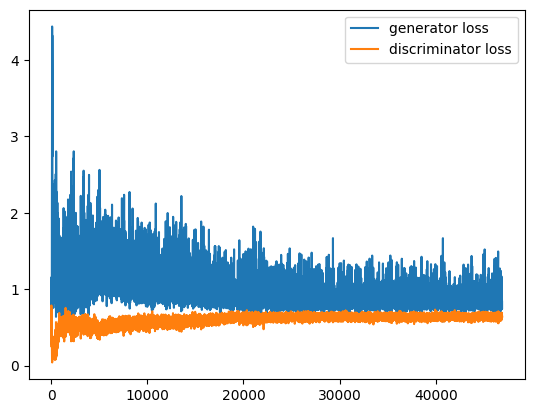

In [25]:
plt.plot(range(len(gener_costs)), gener_costs, label='generator loss')
plt.plot(range(len(discri_costs)), discri_costs, label='discriminator loss')
plt.legend()
plt.show()

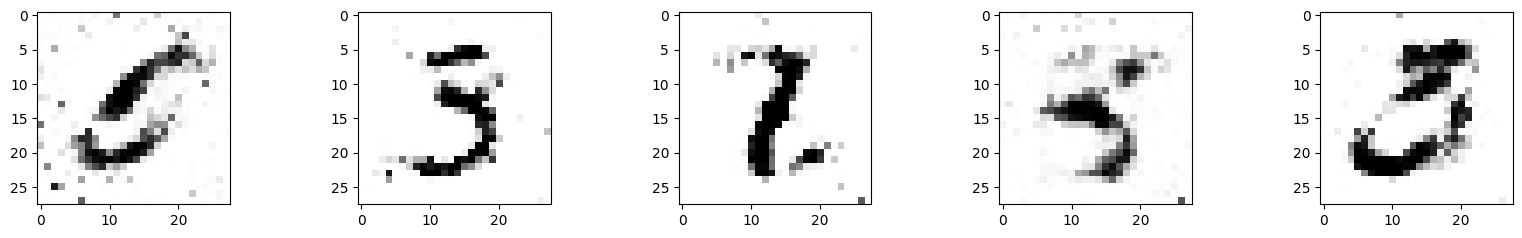

In [26]:
##########################
### VISUALIZATION
##########################


model.eval()
# Make new images
z = torch.zeros((5, LATENT_DIM)).uniform_(-1.0, 1.0).to(device)
generated_features = model.generator_forward(z)
imgs = generated_features.view(-1, 28, 28)

fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 2.5))


for i, ax in enumerate(axes):
    axes[i].imshow(imgs[i].to(torch.device('cpu')).detach(), cmap='binary')